<a href="https://colab.research.google.com/github/sanchit2843/Reinforcementlearningprojects/blob/master/dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev ffmpeg xvfb xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2).
libjpeg-dev is already the newest version (8c-2ubuntu8).
python-dev is already the newest version (2.7.15~rc1-1).
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libboost-all-dev is already the newest version (1.65.1.0ubuntu1).
python-opengl is already the newest version (3.1.0+dfsg-1).
swig is already the newest version (3.0.12-1).
xorg-dev is already the newest version (1:7.7+19ubuntu7.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libsdl2-dev is already the newest version (2.0.8+dfsg1-1ubuntu1.18.04.3).
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 t

In [2]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[len(mp4list)-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

W0621 10:54:59.813594 139926530979712 abstractdisplay.py:144] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


The DQN is collecting experience...


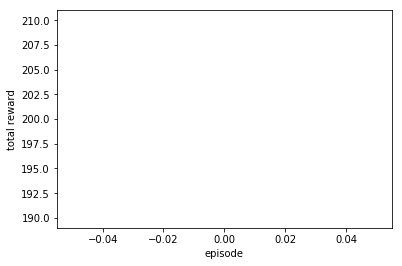

episode 49, the reward is 0.003
episode 50, the reward is 0.071
episode 51, the reward is 0.15
episode 52, the reward is 0.15
episode 53, the reward is 0.115
episode 54, the reward is 0.4
episode 55, the reward is 0.115
episode 56, the reward is 0.168
episode 57, the reward is 0.224
episode 58, the reward is 0.154
episode 59, the reward is -0.01
episode 60, the reward is 0.127
episode 61, the reward is 0.203
episode 62, the reward is 0.136
episode 63, the reward is 0.095
episode 64, the reward is 0.21
episode 65, the reward is 0.158
episode 66, the reward is 0.172
episode 67, the reward is 0.083
episode 68, the reward is 0.104
episode 69, the reward is 0.058
episode 70, the reward is 0.175
episode 71, the reward is 0.058
episode 72, the reward is -0.012
episode 73, the reward is 0.194
episode 74, the reward is 0.379
episode 75, the reward is 0.168
episode 76, the reward is 0.206
episode 77, the reward is 0.08
episode 78, the reward is 0.061
episode 79, the reward is -0.037
episode 80, 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import gym


#hyper parameters

GAMMA = 0.99

LR = 0.001
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 300
BATCH_SIZE = 512

EPISODES = 500
env = wrap_env(gym.make('MountainCar-v0'))
NUM_STATES = env.observation_space.shape[0] # 2
NUM_ACTIONS = env.action_space.n


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(NUM_STATES, 100)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(100, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        return x

class Dqn():
    def __init__(self):
        self.eval_net, self.target_net = Net().to('cuda'), Net().to('cuda')
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES *2 +2))
        # state, action ,reward and next state
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.SGD(self.eval_net.parameters(), LR,momentum = 0.9)
        self.loss = nn.MSELoss()
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)
        self.fig, self.ax = plt.subplots()

    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, [action], [reward], next_state))
        self.memory[index,] = trans
        self.memory_counter += 1

    def choose_action(self, state):
        # notation that the function return the action's index nor the real action
        # EPSILON
        state = torch.unsqueeze(torch.cuda.FloatTensor(state) ,0)
        
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.cpu().numpy() # get action whose q is max
            action = action[0] #get the action index
        else:
            action = np.random.randint(0,NUM_ACTIONS)
        return action

    def plot(self, ax, x):
        ax.cla()
        ax.set_xlabel("episode")
        ax.set_ylabel("total reward")
        ax.plot(x, 'b-')
        plt.pause(0.000000000000001)

    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION ==0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.cuda.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.cuda.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.cuda.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.cuda.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA*q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #self.scheduler.step()


def main():
    net = Dqn()
    print("The DQN is collecting experience...")
    step_counter_list = []
    max_position = -0.4
    EPSILON = 0.65

    for episode in range(EPISODES):
        state = env.reset()
        step_counter = 0
        if(episode%100==0):
          EPSILON = EPSILON+0.05
        while True:
            step_counter +=1
            env.render()
            action = net.choose_action(state)
            next_state, reward, done, info = env.step(action)
            reward = next_state[0] + 0.5
            
            if next_state[0] > max_position:
              max_position = next_state[0]
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
                if done:
                    print("episode {}, the reward is {}".format(episode, round(reward, 3)))
            if done:
                step_counter_list.append(step_counter)
                net.plot(net.ax, step_counter_list)
                break

            state = next_state
    return net
agent = main()

In [0]:
show_video()

In [0]:
env = wrap_env(gym.make('MountainCar-v0'))
observation = env.reset()

while True:
    env.render()
    action = agent.choose_action(observation) 
    observation, reward, done, info = env.step(action)   
    if done: 
      break;
            
env.close()
show_video()